# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [121]:
# импорт библиотек
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [122]:
# выгрузка данных
df = pd.read_csv('/datasets/autos.csv')
# посмотрим на данные
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [123]:
df.shape

(354369, 16)

Признаки:
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя


Целевой признак:
* Price — цена (евро)

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [125]:
# посмотрим на пропуски в данных
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Как видим, в столбцах VehicleType, Gearbox, Model, FuelType, Repaired имеются пропуски в данных.

In [126]:
# проверим на дубликаты
df.duplicated().sum()
df = df.drop_duplicates()

In [127]:
print(df['Repaired'].value_counts())

no     247158
yes     36053
Name: Repaired, dtype: int64


In [128]:
print(df['Repaired'].isna().mean())

0.2007929677027923


In [129]:
# большой процент пропусков, поэтому не можем просто выбросить данные
df['Repaired'].fillna('other', inplace=True)

In [130]:
print(df['Gearbox'].value_counts())

manual    268249
auto       66283
Name: Gearbox, dtype: int64


In [131]:
print(df['Gearbox'].isna().mean())

0.05596771690206426


In [132]:
# заполним пропуски значением "unknown"
df['Gearbox'].fillna('other', inplace=True)

In [133]:
print(df['FuelType'].isna().mean())

0.09282801631086592


In [134]:
print(df['FuelType'].value_counts())

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64


In [135]:
# заполним пропуски значением "unknown"
df['FuelType'].fillna('other', inplace=True)

In [136]:
# посмотрим, во скольких строках отсутствуют данные о модели и 
# 
df[df['Model'].isna()]['VehicleType'].isna().sum()

6828

In [137]:
# эти строки можем смело удалить, а остальные пропуски заполнить самыми 
# распространёнными значениями
col2_mis = df[(df['Model'].isna()) & (df['VehicleType'].isna())]

In [138]:
df = df.drop(col2_mis.index)

In [139]:
df['Model'].value_counts()

golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64

In [140]:
df['Model'].fillna('other', inplace=True)

In [141]:
df['VehicleType'].value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [142]:
df['VehicleType'].fillna('other', inplace=True)

In [143]:
# проверим
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [144]:
# переведём в нижний регистр
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

Избавились от пропусков и дубликатов в данных

Столбцы DateCrawled, NumberOfPictures, PostalCode, LastSeen, Date_Created, вероятно,
будут неважны для дальнейшего анализа, поэтому можем их удалить. 

In [145]:
df.drop(['date_crawled', 'number_of_pictures', 'postal_code', 'last_seen', 'date_created'], axis=1, inplace=True)

In [146]:
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired'],
      dtype='object')

In [147]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,other
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,other
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [148]:
df.describe()

,price,registration_year,power,kilometer,registration_month
count,347537.000000,347537.000000,347537.000000,347537.000000,347537.000000
mean,4463.672023,2003.714301,111.154999,128449.834118,5.770525
std,4524.316698,68.114996,190.551486,37472.194533,3.702718
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1100.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2799.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6499.000000,2007.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


In [149]:
df.dtypes

price                  int64
vehicle_type          object
registration_year      int64
gearbox               object
power                  int64
model                 object
kilometer              int64
registration_month     int64
fuel_type             object
brand                 object
repaired              object
dtype: object

In [150]:
df = df.astype({'registration_month': object,
                'registration_year': object})

Исправили типы данных

In [151]:
# посмотрим на корреляции 
df.corr()

,price,power,kilometer
price,1.000000,0.156006,-0.347183
power,0.156006,1.000000,0.020618
kilometer,-0.347183,0.020618,1.000000


Значительных корреляций нет, можем перейти к обучению модели.

In [152]:
# найдем уникальные значения в столбце "registration_year"
df['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988,
       1965, 1970, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967, 1959,
       1956, 1000, 1941, 9999, 1500, 2200, 1962, 1929, 1957, 1940, 3000,
       2066, 1949, 2019, 1937, 1951, 1953, 8000, 9000, 2900, 5900, 5911,
       1933, 1400, 1950, 4000, 1948, 1952, 1200, 8500, 1932, 3700, 1942,
       1935, 1234, 1936, 6500, 1923, 2290, 1930, 1001, 1944, 7000, 1943,
       1934, 1938, 1928, 1800, 1919, 5555, 6000, 1300, 1931, 1915, 4500,
       1920, 1602, 1111, 7800, 1947, 1927, 7100, 2500, 8200, 1946, 7500,
       1600], dtype=object)

Как видим есть некоторые аномалии: 2066, 1111, 1602, 7500 и т.д. Поэтому эти значения использовать нельзя.

In [153]:
df = df.loc[(df['registration_year'] >= 1900) & (df['registration_year'] <= 2016)]

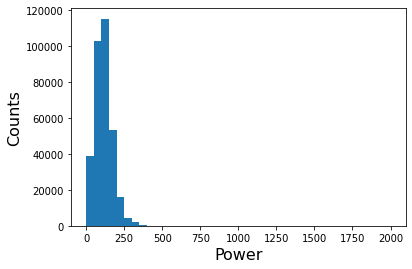

In [154]:
fig, ax = plt.subplots(1, 1)
plt.xlabel("Power", fontsize=16)  
plt.ylabel("Counts", fontsize=16)
plt.hist(df['power'], bins=40, range=[0, 2000])
plt.show()

Самая большая мощность, которая может быть достигнута у спортивных машин 2000 л.с.

In [155]:
df = df.loc[df['power'] <= 2000]

In [156]:
df.loc[df['power'] == 0]
# получается, что есть нулевые значения мощности. Их можно будет заменить медианой

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,other
15,450,small,1910,other,0,ka,5000,0,petrol,ford,other
32,245,sedan,1994,other,0,golf,150000,2,petrol,volkswagen,no
37,1500,other,2016,other,0,kangoo,150000,1,gasoline,renault,no
40,0,other,1990,other,0,corsa,150000,1,petrol,opel,other
...,...,...,...,...,...,...,...,...,...,...,...
354335,390,small,1997,auto,0,corsa,100000,6,petrol,opel,yes
354336,3299,other,2005,auto,0,outlander,150000,4,petrol,mitsubishi,other
354346,2600,other,2005,auto,0,c_klasse,150000,9,other,mercedes_benz,other
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no


In [157]:
df['power'] = df['power'].replace(0, df['power'].mode()[0])

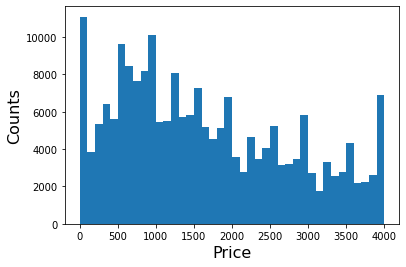

In [158]:
fig, ax = plt.subplots(1, 1)
plt.xlabel("Price", fontsize=16)  
plt.ylabel("Counts", fontsize=16)
plt.hist(df['price'], bins=40, range=[0, 4000])
plt.show()

In [159]:
df.loc[df['price'] == 0]
# есть нулевые значения, то есть их не нужно учитывать

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
40,0,other,1990,other,0,corsa,150000,1,petrol,opel,other
115,0,small,1999,other,0,other,5000,0,petrol,volkswagen,other
152,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes
154,0,other,2006,other,0,other,5000,0,other,fiat,other
...,...,...,...,...,...,...,...,...,...,...,...
354205,0,other,2000,manual,65,corsa,150000,0,other,opel,yes
354238,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,other
354248,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,other
354277,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes


In [160]:
df = df.loc[df['price'] > 0]

## Обучение моделей

In [293]:
data = df

In [294]:
data

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,other
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,other
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


In [295]:
# разделим данные
X = data.drop('price', axis=1)
y = data['price']

In [296]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=12345)

In [297]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=12345)

In [298]:
col = X.columns
col

Index(['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'registration_month', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [299]:
categ = []
for c in X.columns:
  col_type = X[c].dtype
  if col_type == 'object':
    categ.append(c)

In [300]:
print(len(X_train.columns))
print(len(X_test.columns))
print(len(X_valid.columns))

10
10
10


In [301]:
categ

['vehicle_type',
 'registration_year',
 'gearbox',
 'model',
 'registration_month',
 'fuel_type',
 'brand',
 'repaired']

In [302]:
X_train.dtypes

vehicle_type          object
registration_year     object
gearbox               object
power                  int64
model                 object
kilometer              int64
registration_month    object
fuel_type             object
brand                 object
repaired              object
dtype: object

In [303]:
# закодируем признаки с помощью порядкового кодирования
enc = OrdinalEncoder(handle_unknown='ignore')

enc.fit(X_train[categ])

OrdinalEncoder(handle_unknown='ignore')

In [304]:
X_train[categ] = enc.transform(X_train[categ])

In [305]:
X_test[categ] = enc.transform(X_test[categ])

In [306]:
X_valid[categ] = enc.transform(X_valid[categ])

In [307]:
X_train

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
77105,4.0,62.0,1.0,90,20.0,150000,10.0,6.0,1.0,0.0
295759,5.0,64.0,1.0,50,5.0,125000,12.0,6.0,19.0,0.0
295586,4.0,62.0,0.0,0,19.0,150000,10.0,6.0,2.0,0.0
95373,4.0,74.0,2.0,0,115.0,100000,0.0,5.0,38.0,1.0
42687,1.0,83.0,0.0,84,105.0,10000,5.0,6.0,32.0,0.0
...,...,...,...,...,...,...,...,...,...,...
172694,0.0,70.0,1.0,116,202.0,150000,1.0,2.0,38.0,0.0
52142,1.0,69.0,1.0,145,157.0,60000,3.0,6.0,19.0,0.0
93917,5.0,70.0,1.0,169,80.0,150000,1.0,6.0,21.0,0.0
84002,0.0,76.0,1.0,116,202.0,150000,10.0,2.0,38.0,0.0


### Линейная регрессия

In [308]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

predictions_lr_test = model_lr.predict(X_test)
rmse_lr_test = mean_squared_error(y_test, predictions_lr_test) ** 0.5

predictions_lr = model_lr.predict(X_valid)
rmse_lr = mean_squared_error(y_valid, predictions_lr) ** 0.5

print('RMSE линейной модели', rmse_lr)

RMSE линейной модели 3196.8370948274223


### Рещающее дерево

In [309]:
for depth in range(3, 25, 2):
    model = DecisionTreeRegressor(random_state=12345, max_depth = depth)
    model.fit(X_train, y_train)
    
    predictions_test = model.predict(X_test)
    rmse_dtr_test = mean_squared_error(y_test, predictions_test)**0.5
    
    predictions_valid = model.predict(X_valid)
    rmse_dtr = mean_squared_error(y_valid, predictions_valid)**0.5
    
    print('Глубина:', depth)
    print('RMSE для решающего дерева:', rmse_dtr)
    print('')
print()

Глубина: 3
RMSE для решающего дерева: 2923.9164094117314

Глубина: 5
RMSE для решающего дерева: 2435.054929109248

Глубина: 7
RMSE для решающего дерева: 2218.970389620737

Глубина: 9
RMSE для решающего дерева: 2081.585387680923

Глубина: 11
RMSE для решающего дерева: 1993.1214456334549

Глубина: 13
RMSE для решающего дерева: 1974.233027327722

Глубина: 15
RMSE для решающего дерева: 2003.7643803980802

Глубина: 17
RMSE для решающего дерева: 2047.961724978227

Глубина: 19
RMSE для решающего дерева: 2089.0148842010262

Глубина: 21
RMSE для решающего дерева: 2137.9065650846896

Глубина: 23
RMSE для решающего дерева: 2159.5092648130476




Как можно увидеть, модель склонна к переобучению. Лучшая глубина - это 11.

### Случайный лес

In [310]:
for i in tqdm([100, 300, 500, 700]):
    model = RandomForestRegressor(random_state=12345, 
                                   n_estimators=i, 
                                   max_depth=13)
    model.fit(X_train, y_train)
    
    predictions_test = model.predict(X_test)
    rmse_rfr_test = mean_squared_error(y_test, predictions_test)**0.5
    
    predictions_valid = model.predict(X_valid)
    rmse_rfr = mean_squared_error(y_valid, predictions_valid)**0.5
    
    print('Количество деревьев:', i)
    print('RMSE для случайного леса:', rmse_rfr)
    print('')
print()

 25%|██▌       | 1/4 [00:32<01:38, 32.93s/it]

Количество деревьев: 100
RMSE для случайного леса: 1742.9838377269157



 50%|█████     | 2/4 [02:10<02:22, 71.21s/it]

Количество деревьев: 300
RMSE для случайного леса: 1740.4616690306987



 75%|███████▌  | 3/4 [04:45<01:49, 109.39s/it]

Количество деревьев: 500
RMSE для случайного леса: 1739.3634180584277



100%|██████████| 4/4 [08:18<00:00, 124.73s/it]

Количество деревьев: 700
RMSE для случайного леса: 1739.1133693162517




Как видим, результат не сильно зависит от количества деревьев

### LightGBM

In [311]:
!pip3 install lightgbm

In [312]:
import lightgbm as lgb
print(lgb.__version__)

3.3.1


In [313]:
for col in X_train.columns:
  col_type = X_train[col].dtype
  if col_type == 'object':
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')

In [314]:
%%time
model = lgb.LGBMRegressor(random_state=12345)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
rmse_lgbm_test = mean_squared_error(y_test, predictions_test)**0.5

predictions_valid = model.predict(X_valid)
rmse_lgbm = mean_squared_error(y_valid, predictions_valid)**0.5

print('RMSE для LGBM:', rmse_lgbm)

RMSE для LGBM: 1720.4211173414874
CPU times: user 6min 56s, sys: 9.66 s, total: 7min 5s
Wall time: 7min 8s


In [315]:
param_grid = {'n_estimators': [100, 500], 
              'num_leaves': [10, 20, 30]
             }

In [316]:
%%time
model_lgb = lgb.LGBMRegressor(random_state=12345)

hyper_params = GridSearchCV(estimator=model_lgb,
                            param_grid=param_grid)
hyper_params.fit(X_train, y_train)

display(hyper_params.best_params_)
display(hyper_params.best_score_)

{'n_estimators': 500, 'num_leaves': 30}

0.8728760327098302

CPU times: user 18min 35s, sys: 18 s, total: 18min 53s
Wall time: 19min 1s


In [317]:
model_lgb = lgb.LGBMRegressor(n_estimators=500, num_leaves=30, random_state=12345)
model_lgb.fit(X_train, y_train)

predictions_test = model.predict(X_test)
rmse_lgbm_test = mean_squared_error(y_test, predictions_test)**0.5

predictions_valid = model.predict(X_valid)
rmse_lgbm = mean_squared_error(y_valid, predictions_valid)**0.5

print('RMSE для LGBM:', rmse_lgbm)

RMSE для LGBM: 1720.4211173414874


### Dummy regressor

In [318]:
model=DummyRegressor(strategy='mean')

model.fit(X_train, y_train)
prediction_test = model.predict(X_test)

rmse_dr = mean_squared_error(y_test, prediction_test) ** 0.5

print('RMSE для dummy regressor:', rmse_dr)

RMSE для dummy regressor: 4553.392358382987


### CatBoostRegressor

In [319]:
df

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,other
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,other
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


In [320]:
X_train_cbr = X_train
X_test_cbr = X_test
X_valid_cbr = X_valid

In [321]:
X_train_cbr[['vehicle_type', 'registration_year', 'gearbox', 'power', 'brand', 'model','registration_month','fuel_type', 'repaired']] = X_train_cbr[['vehicle_type', 'registration_year', 'gearbox', 'power', 'brand', 'model','registration_month', 'fuel_type', 'repaired']].astype(int)
X_test_cbr[['vehicle_type', 'registration_year', 'gearbox', 'power', 'brand', 'model','registration_month','fuel_type', 'repaired']] = X_test_cbr[['vehicle_type', 'registration_year', 'gearbox', 'power', 'brand', 'model','registration_month', 'fuel_type', 'repaired']].astype(int)
X_valid_cbr[['vehicle_type', 'registration_year', 'gearbox', 'power', 'brand', 'model','registration_month','fuel_type', 'repaired']] = X_valid_cbr[['vehicle_type', 'registration_year', 'gearbox', 'power', 'brand', 'model','registration_month', 'fuel_type', 'repaired']].astype(int)

In [323]:
X_train_cbr[['vehicle_type', 'registration_year', 'gearbox', 'power', 'brand', 'registration_month', 'repaired']] = X_train[['vehicle_type', 'registration_year', 'gearbox', 'power', 'brand','registration_month',  'repaired']].astype('object')
X_test_cbr[['vehicle_type', 'registration_year', 'gearbox', 'power', 'brand', 'registration_month', 'repaired']] = X_test[['vehicle_type', 'registration_year', 'gearbox', 'power', 'brand','registration_month',  'repaired']].astype('object')
X_valid_cbr[['vehicle_type', 'registration_year', 'gearbox', 'power', 'brand', 'registration_month', 'repaired']] = X_valid[['vehicle_type', 'registration_year', 'gearbox', 'power', 'brand','registration_month',  'repaired']].astype('object')

In [324]:
cat = X_train_cbr.select_dtypes(include='object').columns.to_list()

In [325]:
cat

['vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'registration_month',
 'brand',
 'repaired']

In [326]:
model = CatBoostRegressor(loss_function="RMSE", iterations=10)
model.fit(X_train_cbr, y_train, cat_features=cat)

prediction_test = model.predict(X_test_cbr)
rmse_cbr_test = mean_squared_error(y_test, prediction_test) ** 0.5

prediction_valid = model.predict(X_valid_cbr)
rmse_cbr = mean_squared_error(y_valid, prediction_valid) ** 0.5

print('RMSE для CatBoostRegressor:', rmse_cbr)

Learning rate set to 0.5
0:	learn: 3364.9964007	total: 148ms	remaining: 1.33s
1:	learn: 2823.4481240	total: 225ms	remaining: 900ms
2:	learn: 2524.4567777	total: 284ms	remaining: 663ms
3:	learn: 2304.5449012	total: 346ms	remaining: 518ms
4:	learn: 2206.3675282	total: 404ms	remaining: 404ms
5:	learn: 2159.7250583	total: 459ms	remaining: 306ms
6:	learn: 2130.0463087	total: 515ms	remaining: 221ms
7:	learn: 2101.0285893	total: 569ms	remaining: 142ms
8:	learn: 2071.6492792	total: 631ms	remaining: 70.1ms
9:	learn: 2059.4236441	total: 690ms	remaining: 0us
RMSE для CatBoostRegressor: 2037.9485906110694


In [327]:
models = pd.DataFrame([
    ['LinearRegression', rmse_lr],
    ['DecisionTreeRegressor', rmse_dtr],
    ['RandomForestRegressor', rmse_rfr],
    ['LGBMRegressor', rmse_lgbm],
    ['DummyRegressor', rmse_dr],
    ['CatBoostRegressor',rmse_cbr]
],
    columns=['Модель', 'RMSE']
)
models

,Модель,RMSE
0,LinearRegression,3196.837095
1,DecisionTreeRegressor,2159.509265
2,RandomForestRegressor,1739.113369
3,LGBMRegressor,1720.421117
4,DummyRegressor,4553.392358
5,CatBoostRegressor,2037.948591


Лучший результат показывает LGBMRegressor, худший - DummyRegressor.

## Анализ моделей

Проведём анализ времени обучения для всех моделей.

### Линейная реграссия

In [328]:
%%time
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

CPU times: user 129 ms, sys: 34.6 ms, total: 164 ms
Wall time: 109 ms


LinearRegression()

In [329]:
%%time
predictions_lr = model_lr.predict(X_test)

CPU times: user 71.2 ms, sys: 30.9 ms, total: 102 ms
Wall time: 52.7 ms


### Рещающее дерево

In [330]:
%%time
model = DecisionTreeRegressor(random_state=12345, max_depth = 13)
model.fit(X_train, y_train)

CPU times: user 466 ms, sys: 7.94 ms, total: 474 ms
Wall time: 473 ms


DecisionTreeRegressor(max_depth=13, random_state=12345)

In [331]:
%%time
predictions = model.predict(X_valid)

CPU times: user 56.3 ms, sys: 100 µs, total: 56.4 ms
Wall time: 54.9 ms


### Случайный лес

In [332]:
%%time
model = RandomForestRegressor(random_state=12345, 
                                   n_estimators=300, 
                                   max_depth=13)
model.fit(X_train, y_train)

CPU times: user 1min 19s, sys: 174 ms, total: 1min 19s
Wall time: 1min 19s


RandomForestRegressor(max_depth=13, n_estimators=300, random_state=12345)

In [333]:
%%time
predictions = model.predict(X_valid)

CPU times: user 3.08 s, sys: 9.43 ms, total: 3.09 s
Wall time: 3.08 s


### LGBM

In [341]:
X_train.dtypes

vehicle_type          object
registration_year     object
gearbox               object
power                 object
model                  int64
kilometer              int64
registration_month    object
fuel_type              int64
brand                 object
repaired              object
dtype: object

In [342]:
X_train

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
77105,4,62,1,90,20,150000,10,6,1,0
295759,5,64,1,50,5,125000,12,6,19,0
295586,4,62,0,0,19,150000,10,6,2,0
95373,4,74,2,0,115,100000,0,5,38,1
42687,1,83,0,84,105,10000,5,6,32,0
...,...,...,...,...,...,...,...,...,...,...
172694,0,70,1,116,202,150000,1,2,38,0
52142,1,69,1,145,157,60000,3,6,19,0
93917,5,70,1,169,80,150000,1,6,21,0
84002,0,76,1,116,202,150000,10,2,38,0


In [343]:
for col in X_train.columns:
  col_type = X_train[col].dtype
  if col_type == 'object':
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')

In [344]:
%%time
model_lgb = lgb.LGBMRegressor(n_estimators=500, num_leaves=30, random_state=12345)
model_lgb.fit(X_train, y_train)

CPU times: user 15.2 s, sys: 187 ms, total: 15.4 s
Wall time: 15.5 s


LGBMRegressor(n_estimators=500, num_leaves=30, random_state=12345)

In [293]:
%%time
predictions = model.predict(X_valid)

CPU times: user 49.7 ms, sys: 25 µs, total: 49.7 ms
Wall time: 47.5 ms


### CatBoostRegressor

In [336]:
%%time
model = CatBoostRegressor(loss_function="RMSE", iterations=10)
model.fit(X_train_cbr, y_train, cat_features=cat)

Learning rate set to 0.5
0:	learn: 3364.9964007	total: 89.7ms	remaining: 807ms
1:	learn: 2823.4481240	total: 167ms	remaining: 668ms
2:	learn: 2524.4567777	total: 222ms	remaining: 517ms
3:	learn: 2304.5449012	total: 287ms	remaining: 430ms
4:	learn: 2206.3675282	total: 353ms	remaining: 353ms
5:	learn: 2159.7250583	total: 409ms	remaining: 273ms
6:	learn: 2130.0463087	total: 467ms	remaining: 200ms
7:	learn: 2101.0285893	total: 523ms	remaining: 131ms
8:	learn: 2071.6492792	total: 579ms	remaining: 64.3ms
9:	learn: 2059.4236441	total: 637ms	remaining: 0us
CPU times: user 887 ms, sys: 12.1 ms, total: 899 ms
Wall time: 1.28 s


In [337]:
%%time
prediction_test = model.predict(X_valid_cbr)

CPU times: user 83.5 ms, sys: 7.74 ms, total: 91.2 ms
Wall time: 88.3 ms


In [345]:
models_time = pd.DataFrame([
    ['LinearRegression', '109 ms', '52.7 ms'],
    ['DecisionTreeRegressor', '473 ms', '54.9 ms'],
    ['RandomForestRegressor', '1min 19s', '3.08 ms'],
    ['LGBMRegressor', '15.5 s', '47.5 ms'],
    ['CatBoostRegressor','1.28 s', '88.3 ms']
],
    columns=['Модель', 'Время обучения', 'Время предсказания']
)
models_time

,Модель,Время обучения,Время предсказания
0,LinearRegression,109 ms,52.7 ms
1,DecisionTreeRegressor,473 ms,54.9 ms
2,RandomForestRegressor,1min 19s,3.08 ms
3,LGBMRegressor,15.5 s,47.5 ms
4,CatBoostRegressor,1.28 s,88.3 ms


Лучшее время обучения показала модель линейной регрессии, а время предсказания - RandomForestRegressor. Самое большое время обучения у случайного леса. 

Если выбирать лучшую модель исходя из качества модели и времени обучения / предсказания, то LGBMRegressor.

# Вывод

Изначальные данные - это таблица с более чем 350 тыс. строк и 16 столбцами. В ходе предобработки данных мы перевели названия столбцов в нижний регистр, удалили некоторые строки, заполнили пропуски.

Были проверены несколько моделей: LinearRegression, DecisionTreeRegressor, RandomForestRegressor, LGBMRegressor, CatBoostRegressor и DummyRegressor. 
Для решающего дерева и случайного леса мы применили порядковое кодирование. Мы обучили разные модели, подобрали гиперпараметры для них и обнаружили, что модель LightGBM с гиперпараметрами 'n_estimators': 500, 'num_leaves': 50 дает наименьшее значение RMSE: 1852.797.

Было проанализировано время обучения всех моделей. Дольше всего учится модель случайного леса: 6 мин. Модель LightGBM имеет хорошую скорость обучения / предсказания и при этом самую низкую RMSE из всех моделей: на тестовой выборке результат 1852.797.

Наиболее подходящая модель для заказчика по скорости обучения / предсказания и значения ошибки - это LightGBM.